# 학습 목표
1. pydeseq2를 통해 DESeq2 알고리즘(정규화, 분산추정 등)을 파이썬에서 수행한다.
2. COVID-19 RNA-Seq 예시(GSE152418) 데이터를 이용해 실제 DEG를 도출한다.
3. Volcano Plot, Heatmap 시각화를 통해 결과를 해석한다.


# 1. 차등발현 유전자(DEG)란?
- 두 가지(또는 그 이상의) 조건(예: 질병 vs. 정상, 약물 처리 vs. 무처리 등)에서
  통계적으로 유의미한 발현량 차이를 보이는 유전자들입니다.
- RNA-Seq 데이터에서 DEG를 찾으면,
  - 질병 메커니즘 규명
  - 바이오마커 발굴
  - 타겟 선정
  등의 연구에 활용할 수 있습니다.


# 2. 자주 사용되는 라이브러리
- 대부분 R 패키지임.
- DESeq2
    - Raw count 기반 RNA-Seq 데이터 분석에 가장 널리 쓰이는 대표적 패키지
    - Negative binomial 분포 가정, 분산 추정, 정규화(size factor), Wald test, LRT 등 제공
    - 결과로 log2FoldChange, p-value, padj(FDR) 등을 산출하여 DEG를 식별
- edgeR
    - DESeq2와 함께 RNA-Seq 차등발현 분석의 양대 산맥
    - Negative binomial 모델 기반, TMM 정규화 등을 사용
    - 실험 디자인이 다양한 경우(복수 인자, 배치효과 등)에 유연하게 대응 가능
- limma (특히 limma-voom)
    - 원래는 마이크로어레이 분석에 유명했으나, voom 함수로 RNA-Seq 카운트를 마이크로어레이 형태로 변환하여 이용 가능
    - 빠르고 유연한 선형모델 방식, 복합 실험 디자인(배치, 여러 요인) 처리에 강점

# 3. 분석 단계
1. Raw count matrix 준비 (FASTQ → 정렬 → featureCounts)
2. 정규화와 분산 추정 (size factor, negative binomial 등)
3. 통계 검정 (Wald test, likelihood ratio test 등)
4. 다중검정 보정 (FDR, Benjamini-Hochberg)
5. 결과 해석 및 시각화 (Volcano plot, Heatmap 등)

# 4. 라이브러리 설치 및 기본 환경 설정

In [ ]:
!pip install pydeseq2 --quiet
!pip install statsmodels --quiet
!pip install seaborn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# jupyter notebook 내 그래프 표시
%matplotlib inline

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.8 MB/s eta 0:00:00


# 5. 데이터 불러오기

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE152418

실습을 위해 GSE152418의 일부 샘플(Healthy 17명, COVID 17명)로 구성된 count_matrix.csv 파일과 해당 샘플의 메타 정보(Healthy vs. COVID)를 불러옵니다.

- count matrix: row=유전자, col=샘플, 값=read count(정수)
- meta data: 샘플별 condition(Healthy/COVID)


        GSM4614985	S145_nCOV001_C
        GSM4614986	S147_nCoV001EUHM-Draw-1
        GSM4614987	S149_nCoV002EUHM-Draw-2
        GSM4614988	S150_nCoV003EUHM-Draw-1
        GSM4614989	S151_nCoV004EUHM-Draw-1
        GSM4614990	S152_nCoV006EUHM-Draw-1
        GSM4614991	S153_nCoV007EUHM-Draw-1
        GSM4614992	S154_nCoV0010EUHM-Draw-1
        GSM4614993	S155_nCOV021EUHM
        GSM4614994	S156_nCOV024EUHM-Draw-1
        GSM4614995	S157_nCOV0029EUHM
        GSM4614996	S175_nCoV024EUHM-Draw-2
        GSM4614997	S176_nCoV025EUHM-Draw-1
        GSM4614998	S177_nCoV025EUHM-Draw-2
        GSM4614999	S178_nCoV028EUHM-Draw-1
        GSM4615000	S179_nCoV033EUHM-Draw-1
        GSM4615001	S180_nCoV034EUHM-Draw-1
        GSM4615003	S061_257
        GSM4615006	S062_258
        GSM4615008	S063_259
        GSM4615011	S064_260
        GSM4615014	S065_261
        GSM4615016	S066_265
        GSM4615019	S067_270
        GSM4615022	S068_272
        GSM4615025	S069_273
        GSM4615027	S070_279
        GSM4615030	S071_280
        GSM4615032	S181_255
        GSM4615033	S182_SHXA10
        GSM4615034	S183_263
        GSM4615035	S184_SHXA18
        GSM4615036	S185_266
        GSM4615037	S186_SHXA14


In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE152nnn/GSE152418/suppl/GSE152418%5Fp20047%5FStudy1%5FRawCounts.txt.gz
!gunzip GSE152418_p20047_Study1_RawCounts.txt.gz

--2025-03-16 03:24:07--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE152nnn/GSE152418/suppl/GSE152418%5Fp20047%5FStudy1%5FRawCounts.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1726020 (1.6M) [application/x-gzip]
Saving to: ‘GSE152418_p20047_Study1_RawCounts.txt.gz’

GSE152418_p20047_St 100%[===================>]   1.65M  --.-KB/s    in 0.1s    

2025-03-16 03:24:07 (14.6 MB/s) - ‘GSE152418_p20047_Study1_RawCounts.txt.gz’ saved [1726020/1726020]



In [ ]:
df_counts = pd.read_csv("GSE152418_p20047_Study1_RawCounts.txt", sep='\t', index_col=0)
# columns = [Healthy_1..Healthy_17, COVID_1..COVID_17], rows = 각 gene
print("Count matrix shape:", df_counts.shape)
display(df_counts.head(5))

# 메타데이터 구성
df_meta = pd.DataFrame({
    "sample": df_counts.columns,
    "condition": ["COVID"]*17 + ["Healthy"]*17
}).set_index("sample")

print("\nMeta information:")
display(df_meta)

Count matrix shape: (60683, 34)


,S145_nCOV001_C,S147_nCoV001EUHM-Draw-1,S149_nCoV002EUHM-Draw-2,S150_nCoV003EUHM-Draw-1,S151_nCoV004EUHM-Draw-1,S152_nCoV006EUHM-Draw-1,S153_nCoV007EUHM-Draw-1,S154_nCoV0010EUHM-Draw-1,S155_nCOV021EUHM,S156_nCOV024EUHM-Draw-1,...,S068_272,S069_273,S070_279,S071_280,S181_255,S182_SHXA10,S183_263,S184_SHXA18,S185_266,S186_SHXA14
ENSEMBLID,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,1,0,3,16,1,2,18,6,20,0,...,1,1,1,2,3,4,1,0,0,7
ENSG00000278267,3,1,2,0,3,0,0,1,3,2,...,2,7,2,6,3,2,6,12,5,3
ENSG00000243485,2,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
ENSG00000284332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Meta information:


,condition
sample,
S145_nCOV001_C,COVID
S147_nCoV001EUHM-Draw-1,COVID
S149_nCoV002EUHM-Draw-2,COVID
S150_nCoV003EUHM-Draw-1,COVID
S151_nCoV004EUHM-Draw-1,COVID
S152_nCoV006EUHM-Draw-1,COVID
S153_nCoV007EUHM-Draw-1,COVID
S154_nCoV0010EUHM-Draw-1,COVID
S155_nCOV021EUHM,COVID


# 6. DESeq2 파이프라인
- pydeseq2는 DESeq2(원래는 R패키지)의 알고리즘을 파이썬에서 재현한 라이브러리입니다.
- 두 가지 클래스를 주로 사용:
    1. DeseqDataSet: 정규화/분산추정 등 DESeq2 처리
    2. DeseqStats: 통계검정(Wald test) 및 padj(FDR) 계산

- 결과 데이터의 주요 컬럼:
    - baseMean        : 전체 샘플 대비 유전자 발현량 평균
    - log2FoldChange  : (COVID vs Healthy) 로그 폴드 변화
    - pvalue          : p-값
    - padj            : FDR 보정된 p값

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# DeseqDataSet 생성
dds = DeseqDataSet(
    counts=df_counts.T,          # sample x gene의 raw count 데이터프레임 (원래 형태를 보고 전치가 필요할 수 있음)
    metadata=df_meta,          # sample metadata 데이터프레임
    design='~ condition'       # design formula: condition factor를 사용
)

# 실제 DESeq2 처리(정규화, 분산추정 등)
dds.deseq2()

# 통계 검정(Wald test) & 결과 요약
ds = DeseqStats(
    dds,
    contrast=["condition", "COVID", "Healthy"]  # condition 컬럼, 'COVID' vs. 'Healthy' 비교
)
ds.run_wald_test()
ds.summary()

res_df = ds.results_df
print("\nDEG 결과 DataFrame:")
display(res_df.head(10))

Fitting size factors...
... done in 0.10 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 61.26 seconds.

Fitting dispersion trend curve...
... done in 1.67 seconds.

Fitting MAP dispersions...
... done in 73.15 seconds.

Fitting LFCs...
... done in 38.10 seconds.

Calculating cook's distance...
... done in 0.19 seconds.

Replacing 149 outlier genes.

Fitting dispersions...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 0.27 seconds.

Fitting LFCs...
... done in 0.15 seconds.

Running Wald tests...
... done in 14.84 seconds.



Log2 fold change & Wald test p-value: condition COVID vs Healthy
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSEMBLID                                                                  
ENSG00000223972   0.173722        0.981208  2.158106  0.454662  0.649353   
ENSG00000227232   4.903704        2.342295  0.626870  3.736491  0.000187   
ENSG00000278267   3.363780       -1.088766  0.387857 -2.807135  0.004998   
ENSG00000243485   0.111585        0.641752  2.720343  0.235909  0.813504   
ENSG00000284332   0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ENSG00000271254  56.317794       -0.080459  0.186914 -0.430457  0.666863   
ENSG00000275405  11.395651       -0.049760  0.372417 -0.133614  0.893708   
ENSG00000275987   0.048242        0.641753  3.085890  0.207964  0.835257   
ENSG00000277475   0.315633        1.390566  1.423928  0.976571  0.328782   
ENSG00000268674   0.000

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSEMBLID,,,,,,
ENSG00000223972,0.173722,0.981208,2.158106,0.454662,0.649353,NaN
ENSG00000227232,4.903704,2.342295,0.626870,3.736491,0.000187,0.001622
ENSG00000278267,3.363780,-1.088766,0.387857,-2.807135,0.004998,0.022457
ENSG00000243485,0.111585,0.641752,2.720343,0.235909,0.813504,NaN
ENSG00000284332,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000237613,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000268020,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000240361,0.029980,0.472025,3.096568,0.152435,0.878844,NaN
ENSG00000186092,0.153566,0.132567,2.567691,0.051629,0.958824,NaN


# 7. DEG 선별 & 결과 해석
- 통상적으로 padj < 0.05 를 '유의'로 봄
- log2FoldChange >= 1.0 (또는 0.58, 2배 등) 같은 조건을 추가해
의미있게 변화가 큰 유전자를 걸러냄.

In [ ]:
# DEG 필터링
res_df["significant"] = (res_df["padj"] < 0.05) & (res_df["log2FoldChange"].abs() >= 1)
deg_genes = res_df[res_df["significant"]].index
print(f"Number of significant DEG: {len(deg_genes)}")

# 상위 DEG 확인
res_sorted = res_df.sort_values("padj")
print("\nTop 5 significant genes:")
display(res_sorted.head(5))

Number of significant DEG: 3887

Top 5 significant genes:


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,significant
ENSEMBLID,,,,,,,
ENSG00000167900,461.824967,3.130801,0.204500,15.309521,6.604842e-53,2.047171e-48,True
ENSG00000166851,185.042226,3.800298,0.256793,14.799084,1.484900e-49,1.936552e-45,True
ENSG00000171848,844.728133,3.741022,0.253055,14.783407,1.874385e-49,1.936552e-45,True
ENSG00000175063,141.185727,3.487263,0.247833,14.071045,5.721788e-45,4.433671e-41,True
ENSG00000111206,89.854303,3.006387,0.216921,13.859343,1.116915e-43,5.135269e-40,True


# 8. Volcano Plot 시각화
- x축=log2FC
- y축=-log10 p-value
- 결과 해석
   - log2FoldChange > 0: COVID에서 발현이 증가(Up-regulated)된 유전자
   - log2FoldChange < 0: COVID에서 발현이 감소(Down-regulated)된 유전자
   - padj < 0.05일수록 통계적으로 유의하므로, 점들이 위쪽/오른쪽(또는 왼쪽)에 위치

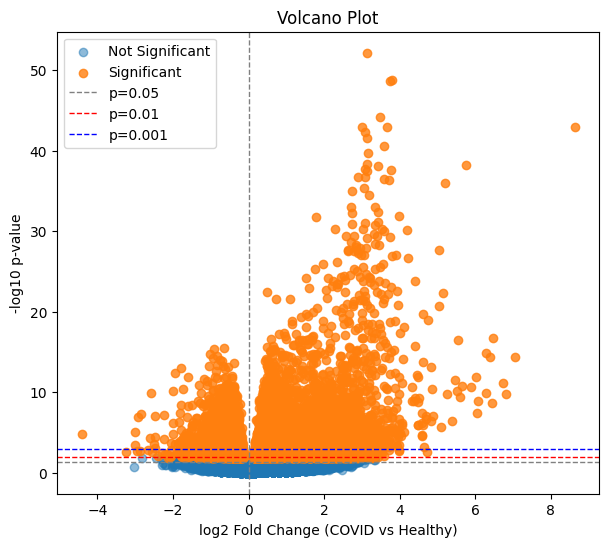

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -log10 p-value 계산
res_df["-log10p"] = -np.log10(res_df["pvalue"].replace(0, 1e-300))

# padj < 0.05인 경우를 Significant로 표시
sig_mask = res_df["padj"] < 0.05

plt.figure(figsize=(7,6))

# Not Significant
plt.scatter(
    res_df.loc[~sig_mask, "log2FoldChange"],
    res_df.loc[~sig_mask, "-log10p"],
    alpha=0.5,
    label="Not Significant"
)

# Significant
plt.scatter(
    res_df.loc[sig_mask, "log2FoldChange"],
    res_df.loc[sig_mask, "-log10p"],
    alpha=0.8,
    label="Significant"
)

# p-value 기준선 (p=0.05)
line_p005 = plt.axhline(-np.log10(0.05), color="gray", linestyle="--", linewidth=1, label="p=0.05")

# p-value 추가 기준선 예시 (p=0.01, p=0.001)
line_p001 = plt.axhline(-np.log10(0.01), color="red", linestyle="--", linewidth=1, label="p=0.01")
line_p0001 = plt.axhline(-np.log10(0.001), color="blue", linestyle="--", linewidth=1, label="p=0.001")

# log2FC = 0 기준선
plt.axvline(0, color="gray", linestyle="--", linewidth=1)

plt.xlabel("log2 Fold Change (COVID vs Healthy)")
plt.ylabel("-log10 p-value")
plt.title("Volcano Plot")

plt.legend()
plt.show()


# 9. Heatmap 시각화
- 상위 DEG의 정규화 카운트 (또는 rlog/vst) 시각화
- pydeseq2에서 추정된 정규화 카운트를 얻어, 상위 DEG를 히트맵으로 표현.
- 결과 해석
   - 상위 DEG 20개 (padj 가장 낮은 유전자)
   - Z-score로 변환했기에, 붉은색=평균보다 높은 발현, 푸른색=평균보다 낮은 발현
   - COVID 샘플(왼쪽 열들) vs. Healthy 샘플(오른쪽 열들)의 발현 패턴 차이를 한눈에 확인

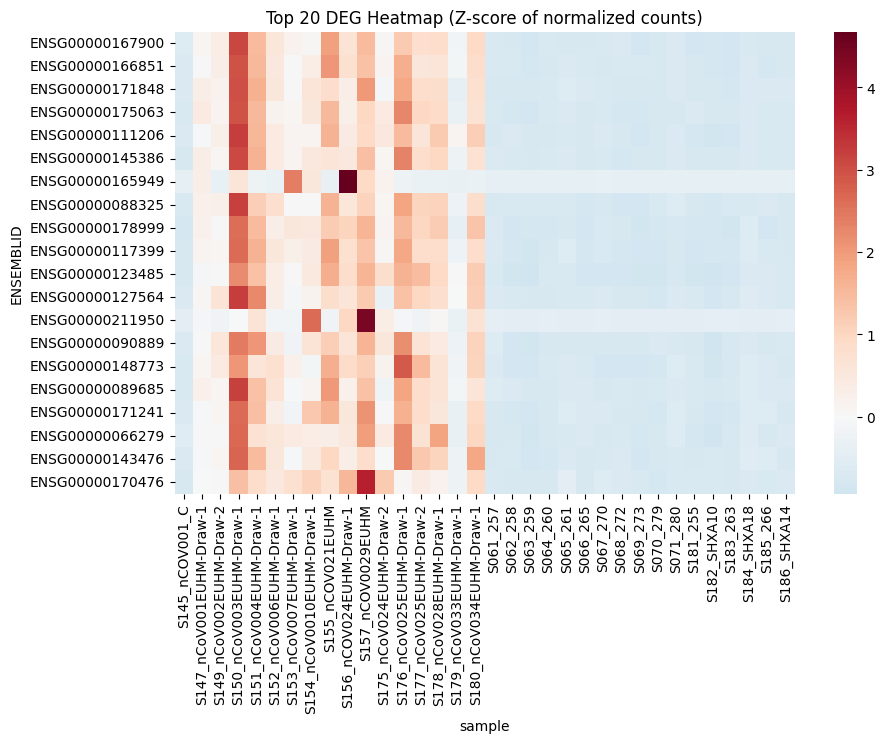

In [ ]:
# 정규화 카운트 DataFrame (유전자 x 샘플)
import pandas as pd
normed_counts_df = pd.DataFrame(
    dds.layers["normed_counts"].T,
    index=dds.var_names,      # 행=유전자
    columns=dds.obs_names     # 열=샘플
)

# DEG 상위 20개 (예: padj가 낮은 순으로 정렬된 res_sorted)
top_genes = res_sorted.head(20).index

# 상위 20개 유전자만 추출
df_top = normed_counts_df.loc[top_genes]

# Z-score 변환 (reshape 방식)
df_zscore = (
    df_top - df_top.mean(axis=1).values.reshape(-1, 1)
) / df_top.std(axis=1).values.reshape(-1, 1)

# 히트맵
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df_zscore, cmap="RdBu_r", center=0)
plt.title("Top 20 DEG Heatmap (Z-score of normalized counts)")
plt.show()

# 10. 결과 저장

In [ ]:
# 전체 결과 DataFrame (DESeq2 결과)
res_df.to_csv("DEG_results_full.csv")

# 유의 DEG만 별도 저장
deg_only_df = res_df[res_df["significant"]]
deg_only_df.to_csv("DEG_results_significant.csv")

# 11. 추가 생물학적 해석
- Up-regulated 유전자들이 어떠한 경로/기능에 관련되는지 (염증 반응, 면역 반응 등)
- Down-regulated 유전자들의 기능 변화가 질병 과정에 어떤 역할을 하는지
- Gene Ontology, KEGG Pathway 분석 등 후속 해석 가능